## Case Study - Comparing Efficacy for a Real-Time Face Detection System

The efficacy of real-time face detection systems is important for their success. Efficacy, in this context, refers to the system"s accuracy, speed, and resource efficiency during operation. This case study will analyze the different face detection methods for a dataset of videos.The following face detection algorithms is included:

- Hog
- Haar
- DNN

These detection models will also be compared against the following library: 
- CVZone


The goal is to provide a understanding of each method"s strengths and weaknesses, focusing on efficacy.

Run the following code block to setup imports: 

In [1]:
# Importing packages for CV2, DLIB and Plotting 
import cv2
import dlib
import matplotlib.pyplot as pyplot

# Import CVzone
from cvzone.FaceMeshModule import FaceMeshDetector

# For benchmarking the process of generating the graph
import time

# For iterating over a folder
import os

# For creating the progress bar when looping over the dataset
from tqdm.notebook import tqdm

# For profiling memory usage 
from memory_profiler import memory_usage

### 1. Code snippets for each model

The following code are the function for each face detection model. The code for the individual models can be found in within `src/models/code/` the `OpenCV_Server` repository. Each file has a function that is called on a single frame. The output is either a list of boundary boxes (`Rect`) or `None`. The functions are moved over to this file for the sake of simplicity.

Run this block to correctly find and import the functions::

In [2]:
import sys 
sys.path.append("../")

# Importing the functions for the face detection models 
from models.code.dnn import detect_face_dnn
from models.code.haar import detect_face_haar
from models.code.hog import detect_face_hog
from models.code.cvzone import detect_face_cvzone

### 2. Data Set

For the Dataset we used a repository created by Intel IoT Development kit. They had a repository with sample videos for testing face detection. See [Resources](#resources) for the link to the dataset. 

We added some of the sample videos. Feel free to use another dataset with videos, and put them in the `data/test_data/videos/` folder. 


Run the code below to setup the path and count how many videos are setup:


In [3]:
# Path to videos 
video_path = "./datasets/videos/"

number_of_videos = len(os.listdir(video_path))
print(f"There are a total of {number_of_videos} videos ready.")

There are a total of 6 videos ready.


### 3. Metrics Evaluation

This case study is going to measure two things: 

- FPS 
- Memory usage 

**Rationale Behind FPS Metric:** The FPS metric is important for measuring the operational speed of face detection models. In the case of real-time detection systems, this is important to process images fast.

**Rationale Behind Memory Usage Metric:** Memory usage offers insights into how computational heavy an algorithm is. Since this will run next to processes that involve computer graphics with Unreal Engine, we need to save memory usage where we can.



### 4. Measuring FPS

FPS is typically used to measure how frequent a set of frames is captured or displayed. In this case, it represents how long it took to process and detect faces using the specific method. 

To find the FPS, we iterate over each frame in the video. For each frame we use the following formula: 

$$ FPS = \frac{1}{(\text{End Time} - \text{Start Time})} $$

We will start a timer before we use a method to detect a face, and then set another timer to calculate how long a method used to process a frame. 

Run the following code block to measure FPS over the dataset: 

In [4]:
# Lists to store FPS stats for each video
average_fps_per_video_haar = []
average_fps_per_video_hog = []
average_fps_per_video_dnn = []
average_fps_per_video_cvzone = []

# Initialize the progress bar for both videos processed 
progress_bar_videos = tqdm(total=number_of_videos, desc="Videos Processed")

# Setting up for the DNN face detection method
modelFile = "./models/trained_models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "./models/trained_models/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

# Setting up the detectors for Haar, Hog and cvzone
haar_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
hog_detector = dlib.get_frontal_face_detector()
cvzone_detector = FaceMeshDetector()

# For each video in the folder, open them 
for video in os.listdir(video_path):
    # Check if the file is a video
    if not video.endswith(".mp4"):
        print("[ERROR] Only MP4 videos are allowed")
        break

    # Full video path 
    path = os.path.join(video_path, video)

    # Open the video
    cap = cv2.VideoCapture(path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    progress_bar_frames_description = "Frame processed in " + video
    progress_bar_frames = tqdm(total=total_frames, desc=progress_bar_frames_description)


    # Temporary lists to store FPS for the current video
    fps_current_video_haar = []
    fps_current_video_hog = []
    fps_current_video_dnn = []
    fps_current_video_cvzone = []
    

    while True:
        # Read frame
        ret, frame = cap.read()
        
        # If there is an error that causes the frame not to be read, we jump over it
        if not ret:
            break
        
        # Process the frame with Haar
        start_time = time.time()
        _ = detect_face_haar(frame, haar_detector, detect_multiple_faces=True)
        end_time = time.time()
        fps_current_video_haar.append(1 / (end_time - start_time))

        # Process the frame with HOG
        start_time = time.time()
        _ = detect_face_hog(frame, hog_detector, detect_multiple_faces=True)
        end_time = time.time()
        fps_current_video_hog.append(1 / (end_time - start_time))

        # Process the frame with DNN
        start_time = time.time()
        _ = detect_face_dnn(frame, net, framework="caffe", conf_threshold=0.89, detect_multiple_faces=True)
        end_time = time.time()
        fps_current_video_dnn.append(1 / (end_time - start_time))

        # Process the frame with CVZone
        start_time = time.time()
        _ = detect_face_cvzone(frame, cvzone_detector, detect_multiple_faces=True)
        end_time = time.time()
        fps_current_video_cvzone.append(1 / (end_time - start_time))


        # Update the process bar for frame processed
        progress_bar_frames.update(1)

    # Close the cap and stop the progress bar    
    progress_bar_frames.close()
    cap.release()

    # Calculate and store the average FPS for the current video for each method
    average_fps_per_video_haar.append(sum(fps_current_video_haar) / len(fps_current_video_haar))
    average_fps_per_video_hog.append(sum(fps_current_video_hog) / len(fps_current_video_hog))
    average_fps_per_video_dnn.append(sum(fps_current_video_dnn) / len(fps_current_video_dnn))
    average_fps_per_video_cvzone.append(sum(fps_current_video_cvzone) / len(fps_current_video_cvzone))


    # Update the progress bar
    progress_bar_videos.update(1)

# Stop the progress bar
progress_bar_videos.close()

# Calculate the average FPS
average_fps_haar = sum(average_fps_per_video_haar) / len(average_fps_per_video_haar) 
average_fps_hog = sum(average_fps_per_video_hog) / len(average_fps_per_video_hog) 
average_fps_dnn = sum(average_fps_per_video_dnn) / len(average_fps_per_video_dnn) 
average_fps_cvzone = sum(average_fps_per_video_cvzone) / len(average_fps_per_video_cvzone) 


Videos Processed:   0%|          | 0/6 [00:00<?, ?it/s]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Frame processed in face-demographics-walking-and-pause_12FPS.mp4:   0%|          | 0/1091 [00:00<?, ?it/s]

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Frame processed in face-demographics-walking_12FPS.mp4:   0%|          | 0/732 [00:00<?, ?it/s]

Frame processed in head-pose-face-detection-female_12FPS.mp4:   0%|          | 0/1615 [00:00<?, ?it/s]

Frame processed in head-pose-face-detection-female-and-male_12FPS.mp4:   0%|          | 0/1719 [00:00<?, ?it/s…

Frame processed in head-pose-face-detection-male_12FPS.mp4:   0%|          | 0/1604 [00:00<?, ?it/s]

Frame processed in classroom_30FPS.mp4:   0%|          | 0/984 [00:00<?, ?it/s]

Plotting the average FPS in graph. This first graph show the average FPS total

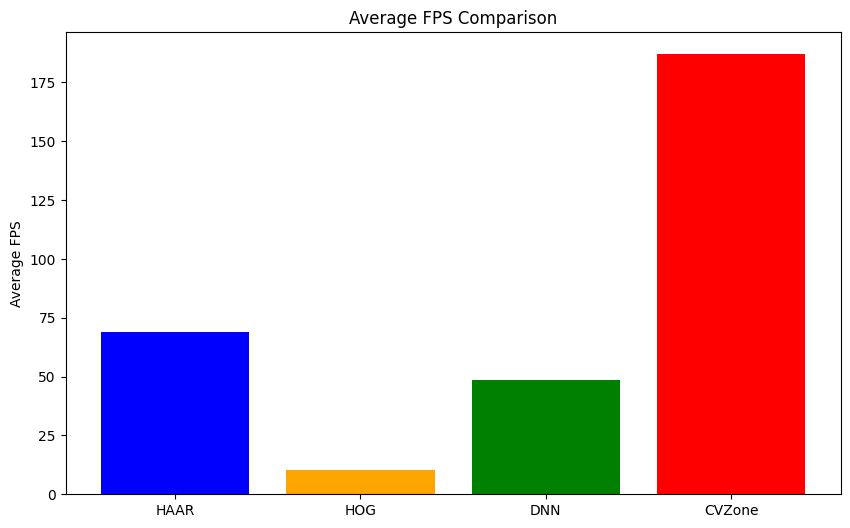

In [5]:
# Method names
methods = ["HAAR", "HOG", "DNN", "CVZone"]

# Average FPS values
fps_values = [average_fps_haar, average_fps_hog, average_fps_dnn, average_fps_cvzone]

# Creating the bar chart
pyplot.figure(figsize=(10, 6))  # Set the figure size (optional)
pyplot.bar(methods, fps_values, color=["blue", "orange", "green", "red"])

# Adding title and labels
pyplot.title("Average FPS Comparison")
pyplot.ylabel("Average FPS")

# Saving the figure to a set path 
pyplot.savefig("./results/compare_face_detection_fps.png")

# Displaying the chart
pyplot.show()


Plotting the average FPS for each video in a line graph. This will give a better understand of how each individual video impacted the FPS result: 

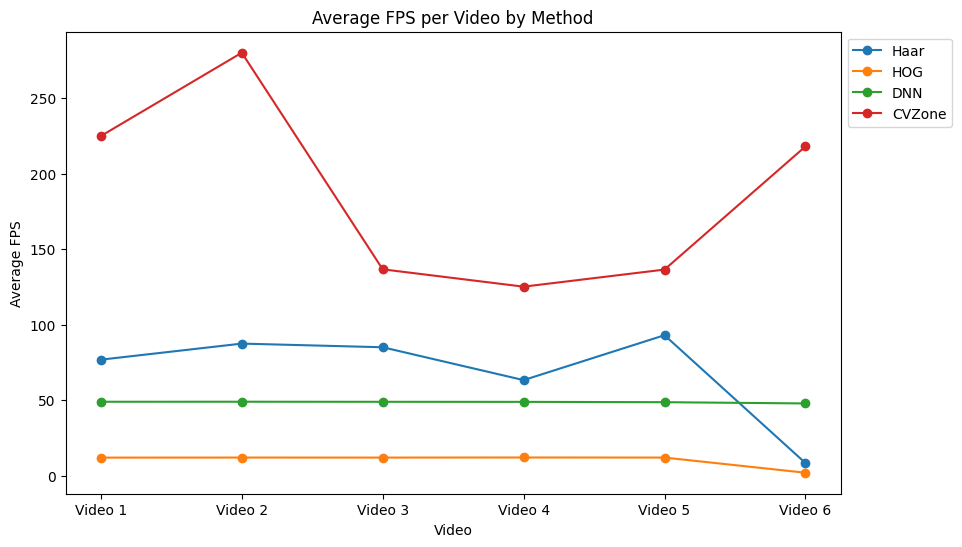

In [6]:
# Adding the three methods into a key-value map
fps_data = {
    "Haar": average_fps_per_video_haar,  
    "HOG": average_fps_per_video_hog,   
    "DNN": average_fps_per_video_dnn,     
    "CVZone": average_fps_per_video_cvzone
}

# Generate video labels dynamically
video_labels = [f"Video {i+1}" for i in range(number_of_videos)]

# Plotting the line chart dynamically
pyplot.figure(figsize=(10, 6))

# Iterate over each method and its FPS data
for method, fps_values in fps_data.items():
    pyplot.plot(video_labels, fps_values, label=method, marker="o")

# Adding title and labels
pyplot.title("Average FPS per Video by Method")
pyplot.xlabel("Video")
pyplot.ylabel("Average FPS")

# Adding a legend
pyplot.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Saving the figure to a set path 
pyplot.savefig("./results/compare_face_detection_fps_per_video.png")

# Displaying the chart
pyplot.show()

### 5. Measuring Memory Usage

For measuring memory usage, we are going to use the package called `memory_profiler`. See [Resources](#resources) for the link to the Python Docs of the module. We are going to use a function that is called `memory_usage`. It measures the usage of the memory of the method given, with what arguments. We also turn on `max_usage` to get the numbers of the highest usage. 

The codeblock below will profile each function for each model and measure memory usage for all videos in the dataset: 

In [7]:
# Lists to store memory usage stats for each video
average_memory_per_video_haar = []
average_memory_per_video_hog = []
average_memory_per_video_dnn = []
average_memory_per_video_cvzone = []

# Initialize the progress bar for videos processed
progress_bar_videos = tqdm(total=number_of_videos, desc="Videos Processed")

# For each video in the folder
for video in os.listdir(video_path):
    if not video.endswith(".mp4"):
        print("[ERROR] Only MP4 videos are allowed")
        break

    path = os.path.join(video_path, video)
    cap = cv2.VideoCapture(path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    progress_bar_frames_description = "Frame processed in " + video
    progress_bar_frames = tqdm(total=total_frames, desc=progress_bar_frames_description)

    # Temporary lists to store memory usage for the current video
    memory_usage_current_video_haar = []
    memory_usage_current_video_hog = []
    memory_usage_current_video_dnn = []
    memory_usage_current_video_cvzone = []

    while True:
        ret, frame = cap.read()

        # If there is an error that causes the frame not to be read, we jump over it
        if not ret:
            break

        # Measure memory usage for Haar
        memory_usage_haar = memory_usage((detect_face_haar, (frame, haar_detector)), max_usage=True)
        memory_usage_current_video_haar.append(memory_usage_haar)

        # Measure memory usage for HOG
        memory_usage_hog = memory_usage((detect_face_hog, (frame, hog_detector)), max_usage=True)
        memory_usage_current_video_hog.append(memory_usage_hog)

        # Measure memory usage for DNN
        memory_usage_dnn = memory_usage((detect_face_dnn, (frame, net)), max_usage=True)
        memory_usage_current_video_dnn.append(memory_usage_dnn)

        # Measure memory usage for CVZone
        memory_usage_cvzone = memory_usage((detect_face_cvzone, (frame, cvzone_detector)), max_usage=True)
        memory_usage_current_video_cvzone.append(memory_usage_cvzone)

        progress_bar_frames.update(1)

    progress_bar_frames.close()
    cap.release()

    # Calculate and store the average memory usage for the current video for each method
    average_memory_per_video_haar.append(sum(memory_usage_current_video_haar) / len(memory_usage_current_video_haar))
    average_memory_per_video_hog.append(sum(memory_usage_current_video_hog) / len(memory_usage_current_video_hog))
    average_memory_per_video_dnn.append(sum(memory_usage_current_video_dnn) / len(memory_usage_current_video_dnn))
    average_memory_per_video_cvzone.append(sum(memory_usage_current_video_cvzone) / len(memory_usage_current_video_cvzone))

    progress_bar_videos.update(1)

progress_bar_videos.close()

# To calculate the average memory usage for each method across all videos
average_memory_haar = sum(average_memory_per_video_haar) / len(average_memory_per_video_haar) 
average_memory_hog = sum(average_memory_per_video_hog) / len(average_memory_per_video_hog) 
average_memory_dnn = sum(average_memory_per_video_dnn) / len(average_memory_per_video_dnn)  
average_memory_cvzone = sum(average_memory_per_video_cvzone) / len(average_memory_per_video_cvzone) 

# Printing out the results
print(f"Average Memory Usage (Haar): {average_memory_haar} MB")
print(f"Average Memory Usage (HOG): {average_memory_hog} MB")
print(f"Average Memory Usage (DNN): {average_memory_dnn} MB")
print(f"Average Memory Usage (CVZone): {average_memory_cvzone} MB")

Videos Processed:   0%|          | 0/6 [00:00<?, ?it/s]

Frame processed in face-demographics-walking-and-pause_12FPS.mp4:   0%|          | 0/1091 [00:00<?, ?it/s]

Frame processed in face-demographics-walking_12FPS.mp4:   0%|          | 0/732 [00:00<?, ?it/s]

Frame processed in head-pose-face-detection-female_12FPS.mp4:   0%|          | 0/1615 [00:00<?, ?it/s]

Frame processed in head-pose-face-detection-female-and-male_12FPS.mp4:   0%|          | 0/1719 [00:00<?, ?it/s…

Frame processed in head-pose-face-detection-male_12FPS.mp4:   0%|          | 0/1604 [00:00<?, ?it/s]

Frame processed in classroom_30FPS.mp4:   0%|          | 0/984 [00:00<?, ?it/s]

Average Memory Usage (Haar): 396.61106923907073 MB
Average Memory Usage (HOG): 399.51834915726226 MB
Average Memory Usage (DNN): 398.307202717016 MB
Average Memory Usage (CVZone): 397.7627231552788 MB


Plotting the result in two graphs. First the a bar graph for the average memory per method: 

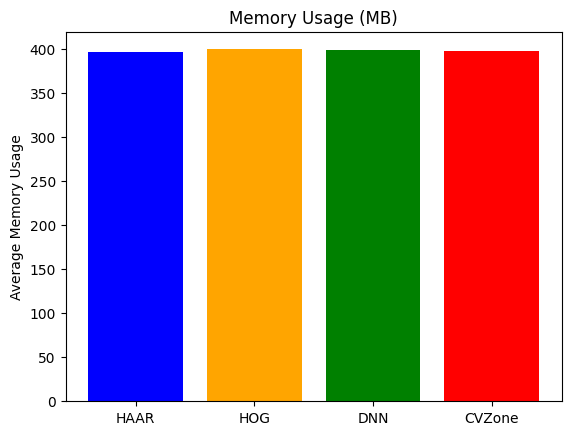

In [8]:
# Method names
methods = ["HAAR", "HOG", "DNN", "CVZone"]

# Average FPS values
memory_values = [average_memory_haar, average_memory_hog, average_memory_dnn , average_memory_cvzone]

# Creating the bar chart
pyplot.bar(methods, memory_values, color=["blue", "orange", "green", "red"])

# Adding title and labels
pyplot.title("Memory Usage (MB)")
pyplot.ylabel("Average Memory Usage")

# Saving the figure to a set path 
pyplot.savefig("./results/compare_face_detection_memory.png")

# Displaying the chart
pyplot.show()

This next graph shows memory usage for each video by each method: 

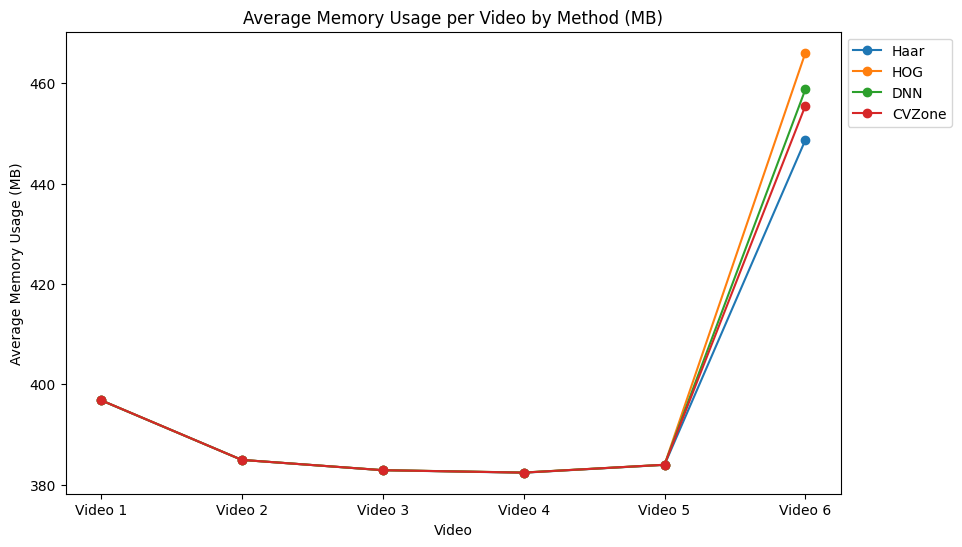

In [9]:
# Adding the three methods into a 
memory_data = {
    "Haar": average_memory_per_video_haar,  
    "HOG": average_memory_per_video_hog,   
    "DNN": average_memory_per_video_dnn,     
    "CVZone": average_memory_per_video_cvzone
}

# Generate video labels dynamically
videos = [f"Video {i+1}" for i in range(number_of_videos)]

# Plotting the line chart dynamically
pyplot.figure(figsize=(10, 6))

# Iterate over each method and its FPS data
for method, memory_values in memory_data.items():
    pyplot.plot(videos, memory_values, label=method, marker="o")

# Adding title and labels
pyplot.title("Average Memory Usage per Video by Method (MB)")
pyplot.xlabel("Video")
pyplot.ylabel("Average Memory Usage (MB)")

# Adding a legend
pyplot.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Saving the figure to a set path 
pyplot.savefig("./results/compare_face_detection_memory_per_video.png")

# Displaying the chart
pyplot.show()

### Resources

This section is the list of resources that was used to setup this case study. Both scientific articles and docs will be linked below: 

What are FPS (Wikipedia article): <br>
https://en.wikipedia.org/wiki/Frame_rate 

Memory Profiler Docs: <br>
https://pypi.org/project/memory-profiler/

Intel IoT Developer Kit Sample Videos: <br>
https://github.com/intel-iot-devkit/sample-videos?tab=readme-ov-file#samples-videos 

Matplotlib Docs (For creating the graphs): <br>
https://matplotlib.org/stable/index.html 


Check out the GitHub repository here: [GitHub Repository](https://github.com/RIT-NTNU-Bachelor/case-study)

**Created by:** Kjetil Indrehus, Sander Hauge and Martin Johannessen


